In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\alvan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [3]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [9]:
def polarity_scores_roberta(text):
    labels = [-1, 0, 1]
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', max_length=511, truncation=True)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    i, = np.where(scores == scores.max())
    return scores_dict, labels[i[0]]

## Bitcoin

In [10]:
btc_df = pd.read_csv(f'BTC_Tweets.csv', index_col=0)

In [11]:
btc_df.head()

,Date,Retweet,Reply,Likes,Tweet
0,2020-01-01 18:23:45+00:00,82,1,2989,@NightlyEspresso @twilightsthorn Shrek 5: Inve...
1,2020-01-01 02:20:38+00:00,362,43,2018,This decade was bitcoin just warming up.
2,2020-01-01 15:12:05+00:00,161,56,1840,BREAKING: Bitcoin's price just set a new yearl...
3,2020-01-01 02:12:10+00:00,230,140,1798,$BTC\n\nI'm pretty sure we're gonna bounce big...
4,2020-01-01 23:58:54+00:00,115,150,1732,I bought my wife some Bitcoin to help her unde...


In [12]:
roberta_result = {}
classes = []
for i, row in tqdm(btc_df.iterrows(), total=len(btc_df)):
    text = row['Tweet']
    result = polarity_scores_roberta(text)
    roberta_result[i] = {**result[0]}
    classes.append(result[1])

100%|██████████| 17040/17040 [38:35<00:00,  7.36it/s] 


In [13]:
btc_df = btc_df.join(pd.DataFrame(roberta_result).T)
btc_df['classes'] = classes

btc_df.head()

,Date,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
0,2020-01-01 18:23:45+00:00,82,1,2989,@NightlyEspresso @twilightsthorn Shrek 5: Inve...,0.035846,0.865769,0.098386,0
1,2020-01-01 02:20:38+00:00,362,43,2018,This decade was bitcoin just warming up.,0.029965,0.760136,0.209899,0
2,2020-01-01 15:12:05+00:00,161,56,1840,BREAKING: Bitcoin's price just set a new yearl...,0.002858,0.214380,0.782763,1
3,2020-01-01 02:12:10+00:00,230,140,1798,$BTC\n\nI'm pretty sure we're gonna bounce big...,0.002113,0.070673,0.927214,1
4,2020-01-01 23:58:54+00:00,115,150,1732,I bought my wife some Bitcoin to help her unde...,0.514108,0.369716,0.116176,-1


In [14]:
btc_df.to_csv('sentiment_btc.csv')

In [15]:
btc_df['Date'] = pd.to_datetime(btc_df['Date']).dt.date
btc_df1 = btc_df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

In [16]:
dff = pd.read_csv(r'BTC_tweet_perday.csv', index_col=0)

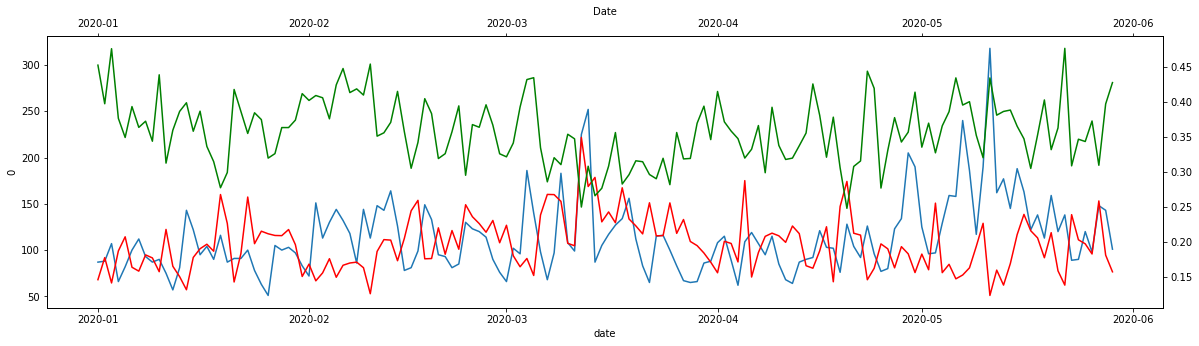

In [19]:
date = []
for i in range(150):
    date.append(pd.to_datetime('2020-01-01') + pd.Timedelta(days=i))

dff['date'] = date
fig = plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='date', y='0', data=dff)
ax2 = ax.twinx()
ax3 = ax2.twiny()
ax2 = sns.lineplot(x='Date', y='roberta_neg', data=btc_df1, color='r')
ax3 = sns.lineplot(x='Date', y='roberta_pos', data=btc_df1, color='g')

plt.show()

## Ethereum

In [20]:
eth_df = pd.read_csv(f'ETH_Tweets.csv', index_col=0)

In [21]:
eth_df.head()

,Date,Retweet,Reply,Likes,Tweet
0,2020-01-01 08:18:15+00:00,126,57,979,If you bought any crypto and it went up over 1...
1,2020-01-01 20:15:56+00:00,161,179,941,I found @CryptoKitties the most interesting cr...
2,2020-01-01 01:24:27+00:00,54,29,877,Happy New Year to all you great people in the ...
3,2020-01-01 12:53:38+00:00,77,47,778,$ETH\n\nTime to play the range. https://t.co/I...
4,2020-01-01 06:54:45+00:00,209,84,734,Crypto companies by number of fulltime employe...


In [22]:
roberta_result = {}
classes = []
for i, row in tqdm(eth_df.iterrows(), total=len(eth_df)):
    text = row['Tweet']
    result = polarity_scores_roberta(text)
    roberta_result[i] = {**result[0]}
    classes.append(result[1])

100%|██████████| 6931/6931 [18:33<00:00,  6.22it/s]


In [23]:
eth_df = eth_df.join(pd.DataFrame(roberta_result).T)
eth_df['classes'] = classes

In [24]:
eth_df.head()

,Date,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
0,2020-01-01 08:18:15+00:00,126,57,979,If you bought any crypto and it went up over 1...,0.800818,0.171669,0.027513,-1
1,2020-01-01 20:15:56+00:00,161,179,941,I found @CryptoKitties the most interesting cr...,0.001476,0.022359,0.976165,1
2,2020-01-01 01:24:27+00:00,54,29,877,Happy New Year to all you great people in the ...,0.001505,0.009942,0.988553,1
3,2020-01-01 12:53:38+00:00,77,47,778,$ETH\n\nTime to play the range. https://t.co/I...,0.051264,0.882905,0.065831,0
4,2020-01-01 06:54:45+00:00,209,84,734,Crypto companies by number of fulltime employe...,0.013984,0.510773,0.475243,0


In [25]:
eth_df.to_csv('sentiment_eth.csv')

In [26]:
eth_df['Date'] = pd.to_datetime(eth_df['Date']).dt.date
eth_df1 = eth_df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

In [27]:
dff = pd.read_csv(r'ETH_tweet_perday.csv', index_col=0)

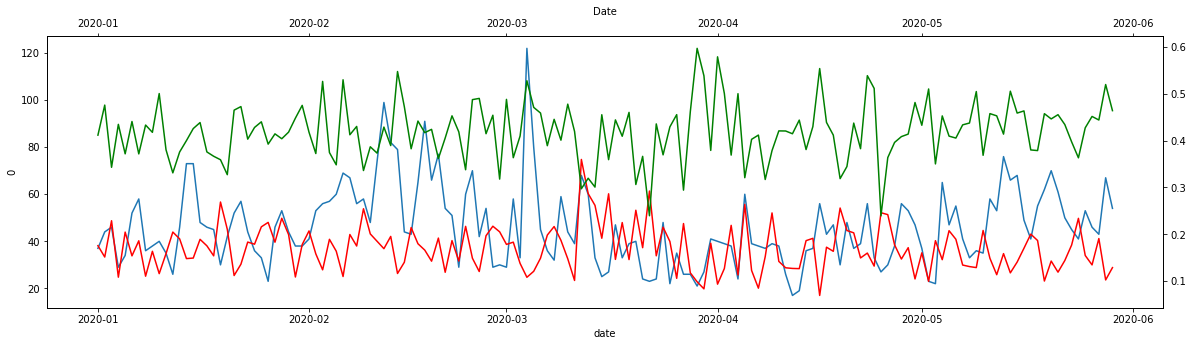

In [29]:
date = []
for i in range(150):
    date.append(pd.to_datetime('2020-01-01') + pd.Timedelta(days=i))

dff['date'] = date
fig = plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='date', y='0', data=dff)
ax2 = ax.twinx()
ax3 = ax2.twiny()
ax2 = sns.lineplot(x='Date', y='roberta_neg', data=eth_df1, color='r')
ax3 = sns.lineplot(x='Date', y='roberta_pos', data=eth_df1, color='g')

plt.show()